# Module 07: Multivariate Adaptive Regression Splines

## Prerequisites

In [1]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *

# Modeling packages
from pyearth import Earth
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.inspection import partial_dependence

In [2]:
# Ames housing data
ames = pd.read_csv("../data/ames.csv")

# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train[["Sale_Price"]]

## Fitting a basic model

In [3]:
# Step 1: create model object
earth_mod = Earth()

# Step 2: fit/train model
earth_fit = earth_mod.fit(X_train[["Gr_Liv_Area", "Year_Built"]], y_train)

# Step 3: results
print(earth_fit.summary())

Earth Model
------------------------------------------
Basis Function       Pruned  Coefficient  
------------------------------------------
(Intercept)          No      392053       
h(Gr_Liv_Area-3500)  No      -379.207     
h(3500-Gr_Liv_Area)  No      -85.3651     
h(Year_Built-2009)   No      142719       
h(2009-Year_Built)   No      -1136.79     
h(Gr_Liv_Area-1905)  No      46.5807      
h(1905-Gr_Liv_Area)  Yes     None         
h(Gr_Liv_Area-3140)  No      194.026      
h(3140-Gr_Liv_Area)  Yes     None         
h(Gr_Liv_Area-2798)  Yes     None         
h(2798-Gr_Liv_Area)  Yes     None         
------------------------------------------
MSE: 2114325265.1482, GCV: 2147703342.5369, RSQ: 0.6767, GRSQ: 0.6719


In [4]:
# RMSE
np.sqrt(earth_fit.mse_)

45981.7927570051

## Fitting a full model

In [5]:
# create new feature set with encoded features
X_train_encoded = pd.get_dummies(X_train)

In [6]:
# create model object
earth_mod = Earth()

# fit/train model
earth_fit_full = earth_mod.fit(X_train_encoded, y_train)

# results
print(earth_fit_full.summary())

Earth Model
--------------------------------------------------
Basis Function               Pruned  Coefficient  
--------------------------------------------------
(Intercept)                  No      -177719      
h(Gr_Liv_Area-3112)          No      59.5685      
h(3112-Gr_Liv_Area)          No      -60.3777     
h(Total_Bsmt_SF-2271)        Yes     None         
h(2271-Total_Bsmt_SF)        No      -1028.23     
Bsmt_Qual_Excellent          No      18871.5      
Year_Built                   No      413.296      
h(Garage_Area-736)           No      58.9552      
h(736-Garage_Area)           No      -23.0269     
h(Bsmt_Unf_SF-1065)          No      -21.4074     
h(1065-Bsmt_Unf_SF)          No      18.7046      
h(Total_Bsmt_SF-2140)        Yes     None         
h(2140-Total_Bsmt_SF)        No      775.194      
h(Total_Bsmt_SF-1922)        Yes     None         
h(1922-Total_Bsmt_SF)        Yes     None         
Kitchen_AbvGr                No      -33360.4     
Kitchen_Qual_Excell

In [7]:
# RMSE
np.sqrt(earth_fit_full.mse_)

24451.324858928252

## Fitting a full model with interactions

In [8]:
# create model object
earth_mod = Earth(max_degree=2)

# fit/train model
earth_fit_int = earth_mod.fit(X_train_encoded, y_train)

# results
print(earth_fit_int.summary())

Earth Model
-------------------------------------------------------------------
Basis Function                               Pruned  Coefficient   
-------------------------------------------------------------------
(Intercept)                                  No      -2.29143e+06  
h(Gr_Liv_Area-3112)                          No      180.773       
h(3112-Gr_Liv_Area)                          No      -79.6032      
h(Total_Bsmt_SF-2271)                        No      -1485.52      
h(2271-Total_Bsmt_SF)                        No      1323.11       
Bsmt_Qual_Excellent                          No      26694.9       
Year_Built                                   No      1116.61       
h(Total_Bsmt_SF-1930)*Year_Built             No      0.747973      
h(1930-Total_Bsmt_SF)*Year_Built             No      -0.692553     
h(Bsmt_Unf_SF-1065)*h(3112-Gr_Liv_Area)      No      -0.0273563    
h(1065-Bsmt_Unf_SF)*h(3112-Gr_Liv_Area)      No      0.0106462     
Land_Contour_Bnk*h(Gr_Liv_Area-3112)

## Tuning

In [9]:
# create model object
earth_mod = Earth()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'max_terms': range(1, 51, 3),
              'max_degree': range(1, 3)}

In [ ]:
grid_search = GridSearchCV(earth_mod, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)

# Optimal penalty parameter in grid search
results.best_estimator_

In [ ]:
# Best model's cross validated RMSE
round(abs(results.best_score_), 2)

In [ ]:
results_df = pd.DataFrame(results.cv_results_.get("params"))
results_df['RMSE'] = np.abs(results.cv_results_.get("mean_test_score"))
results_df['max_degree'] = results_df['max_degree'].astype(str)

(ggplot(results_df, aes('max_terms', 'RMSE', color='max_degree'))
  + geom_line()
  + geom_point()
  )

## Feature interpretation

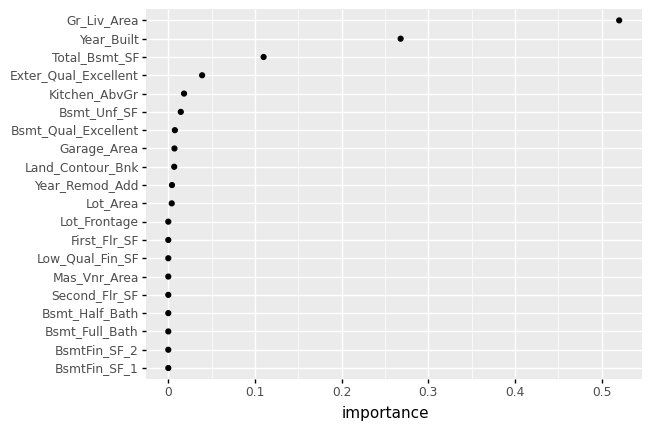

<ggplot: (320611850)>

In [10]:
best_mod = Earth(max_degree=2, max_terms=31, feature_importance_type='rss')
best_mod_fit = best_mod.fit(X_train_encoded, y_train)

vi = pd.DataFrame({'feature': best_mod_fit.xlabels_,
              'importance': best_mod_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

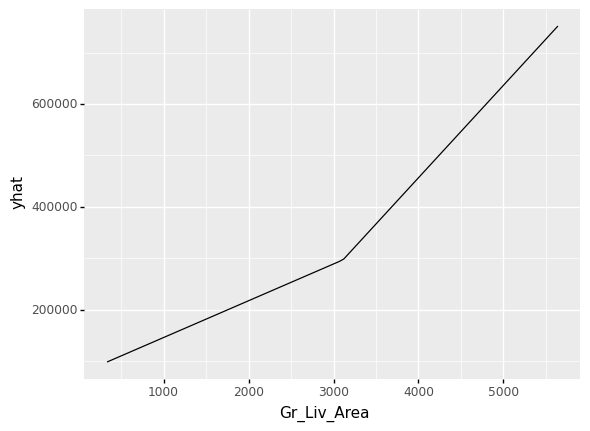

<ggplot: (322857322)>

In [11]:
pd_results = partial_dependence(
  best_mod_fit, X_train_encoded, "Gr_Liv_Area", kind='average',
  percentiles=(0, 1)) 
  
pd_output = pd.DataFrame({'Gr_Liv_Area': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('Gr_Liv_Area', 'yhat'))
  + geom_line())

## Exercises

Using the `hitters` dataset:

1. Apply a MARS model with all features.
2. How does the model performance compare to your previous models?
3. How many of the features are influential? Which 10 features are considered most influential?
4. Does your model include hinge functions? If so, explain their coefficient and plot their impact on the predicted response variable.
5. Does your model include interactions? If so, pick the interaction effect that is most influential and explain the coefficient.